In [1]:
from dask.distributed import Client, LocalCluster
client = Client(n_workers=10,threads_per_worker=10,processes=True)
client

/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37715 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:41083 Dashboard: http://127.0.0.1:37715/status,Cluster Workers: 10 Cores: 100 Memory: 67.54 GB


In [2]:
import xarray as xr
import numpy as np

In [3]:
# 0-360
lon_lim = [0,360]
lat_lim = [-20,20]

In [75]:
import importlib
import io_model
importlib.reload(io_model)
from io_model import E3SM_COARE_io

ds_coare30 = E3SM_COARE_io(lon_lim,lat_lim,case='coare30').compute()
ds_coare30['del_q'] = ds_coare30['del_q']*1e3

In [76]:
ds_coare35 = E3SM_COARE_io(lon_lim,lat_lim,case='coare35').compute()
ds_coare35['del_q'] = ds_coare35['del_q']*1e3

In [77]:
from memory import used_memory
used_memory()

used 971.351562 MB


In [24]:
import importlib
import ocean_mask
importlib.reload(ocean_mask)
from ocean_mask import levitus98
# import ocean mask
da_mask_atlantic_regrid,da_mask_indian_regrid,da_mask_pacific_regrid,da_3basin,da_indopac = levitus98(ds_coare35,
                       basin=['all'],
                       reuse_weights=False, 
                       newvar=True, 
                       lon_name='lon',
                       lat_name='lat', 
                       new_regridder_name='')

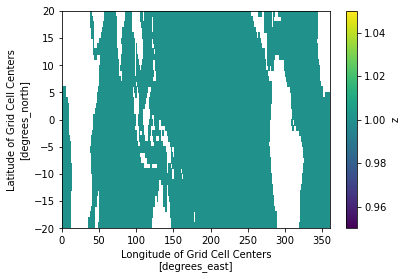

In [26]:
da_3basin.plot()

In [78]:
ds_coare30 = ds_coare30*da_3basin
ds_coare35 = ds_coare35*da_3basin

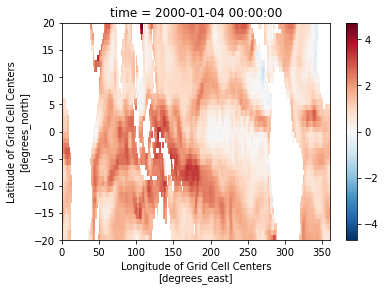

In [71]:
(ds_coare30.TS-ds_coare30.TREFHT).isel(time=2).plot()

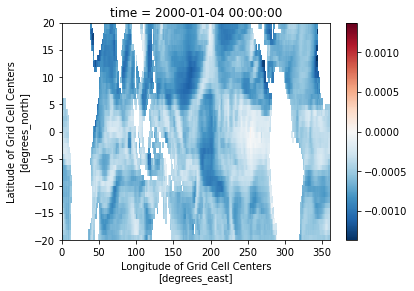

In [81]:
(ds_coare30.QBOT-ds_coare30.QREFHT).isel(time=2).plot()

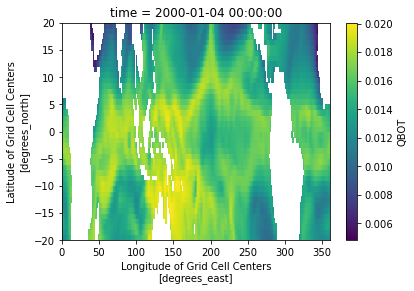

In [82]:
ds_coare30.QBOT.isel(time=2).plot()

# Binning the latent heat flux

In [79]:
import importlib
import groupby_variables
importlib.reload(groupby_variables)
from groupby_variables import bin_2d

stt = 0.99

nbin1 = 16
bin1_range = [0,16]

nbin2 = 14
bin2_range = [0,14]


ds_coare30_bin = bin_2d(ds_coare30,'sfcWind','del_q',['hfls','dT'],
                          bin1=nbin1,bin2=nbin2,stTconfint=stt,
                          bin1_range=bin1_range,
                          bin2_range=bin2_range)
ds_coare35_bin = bin_2d(ds_coare35,'sfcWind','del_q',['hfls','dT'],
                          bin1=nbin1,bin2=nbin2,stTconfint=stt,
                          bin1_range=bin1_range,
                          bin2_range=bin2_range)


hfls
dT
hfls
dT


In [10]:
used_memory()

used 308.890625 MB


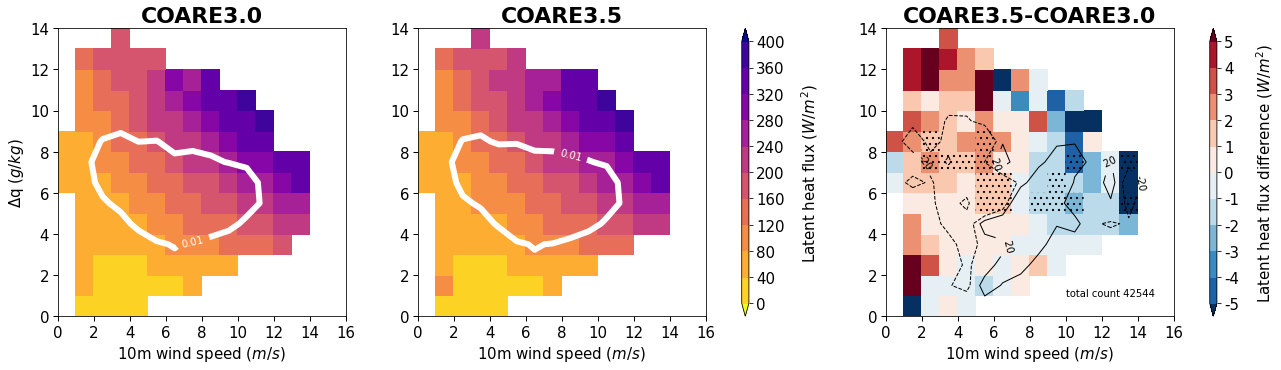

In [87]:
import matplotlib.pyplot as plt

fig = plt.figure(1,figsize=(5,5))

qlat_level = np.linspace(0,400,11)
dqlat_level = np.linspace(-5,5,11)
qlatratio_level = np.linspace(-0.2,0.2,11)
ratiolevel = np.linspace(0.01,0.01,1)
countdifflevel = np.linspace(-20,20,2)
 
# ======== WTP qnet =========
ax1 = fig.add_axes([0,0,1,0.8])
im = ds_coare30_bin['hfls'].plot.pcolormesh(x='sfcWind',
                                          y='del_q',
                                          ax=ax1,
                                          levels=qlat_level, 
                                          extend='both', 
                                          cmap='plasma_r',)
cb=im.colorbar
cb.remove() 
# cbaxes=fig.add_axes([0,0-0.2,0.8,0.02])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(qlat_level)
# cbar.set_ticklabels(["%0.0f"%(n) for n in qlat_level])
# cbar.ax.tick_params(labelsize=15,rotation=45) 
# cbar.set_label(label='Latent heat flux ($W/m^2$)',size=15, labelpad=15)


            
cs = (ds_coare30_bin['hfls_count']/ds_coare30_bin['hfls_count'].sum())\
                            .plot.contour(x='sfcWind',
                                          y='del_q',
                                          ax=ax1,
                                          levels=ratiolevel, 
                                          colors='w',linewidths=6)
ax1.clabel(cs, ratiolevel, inline=True, fmt='%0.2f', fontsize=10)

# ========== WTP qlat ===========
ax2 = fig.add_axes([1,0,1,0.8])
im = ds_coare35_bin['hfls'].plot.pcolormesh(x='sfcWind',
                                          y='del_q',
                                          ax=ax2,
                                          levels=qlat_level, 
                                          extend='both', 
                                          cmap='plasma_r',)
cb=im.colorbar
cb.remove()
# cbaxes=fig.add_axes([1,0-0.2,0.8,0.02])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(qlat_level)
# cbar.set_ticklabels(["%0.0f"%(n) for n in qlat_level])
# cbar.ax.tick_params(labelsize=15,rotation=45) 
# cbar.set_label(label='Latent heat flux ($W/m^2$)',size=15, labelpad=15)


cs = (ds_coare35_bin['hfls_count']/ds_coare35_bin['hfls_count'].sum())\
                            .plot.contour(x='sfcWind',
                                          y='del_q',
                                          ax=ax2,
                                          levels=ratiolevel, 
                                          colors='w',linewidths=6)
ax2.clabel(cs, ratiolevel, inline=True, fmt='%0.2f', fontsize=10)


cbaxes=fig.add_axes([1.9,0,0.02,0.8])
cbar=fig.colorbar(im,cax=cbaxes,orientation='vertical')
cbar.set_ticks(qlat_level)
cbar.set_ticklabels(["%0.0f"%(n) for n in qlat_level])
cbar.ax.tick_params(labelsize=15,rotation=0) 
cbar.set_label(label='Latent heat flux ($W/m^2$)',size=15, labelpad=15)


ax1.set_yticks(np.arange(bin2_range[0],bin2_range[1]+1,2))
ax1.set_xticks(np.arange(bin1_range[0],bin1_range[1]+1,2))
# ax1.set_yticklabels(np.arange(0,13,1), color='black',size=15)
ax1.set_xlim([bin1_range[0],bin1_range[1]])
ax1.set_ylim([bin2_range[0],bin2_range[1]])
ax1.tick_params(axis='y',labelsize=15,length=5,width=1) 
ax1.tick_params(axis='x',labelsize=15,length=5,width=1) 
# ax2.grid(linewidth=2, color='grey', alpha=0.3, linestyle='--')
ax1.set_ylabel('$\Delta$q ($g/kg$)',size=15)
ax1.set_xlabel('10m wind speed ($m/s$)',size=15)
ax1.set_title('COARE3.0',color='black', weight='bold',size=22)
# ax2.legend(loc='lower left',fontsize=20,frameon=False)

ax2.set_yticks(np.arange(bin2_range[0],bin2_range[1]+1,2))
ax2.set_xticks(np.arange(bin1_range[0],bin1_range[1]+1,2))
# ax2.set_yticklabels(np.arange(0,13,1), color='black',size=15)
ax2.set_xlim([bin1_range[0],bin1_range[1]])
ax2.set_ylim([bin2_range[0],bin2_range[1]])
ax2.tick_params(axis='y',labelsize=15,length=5,width=1) 
ax2.tick_params(axis='x',labelsize=15,length=5,width=1) 
ax2.set_ylabel('',size=15)
ax2.set_xlabel('10m wind speed ($m/s$)',size=15)
ax2.set_title('COARE3.5',color='black', weight='bold',size=22)
# ax2.legend(loc='lower left',fontsize=20,frameon=False)


# ========== WTP qlat ===========
dx=0.3

ds_diff_bin = ds_coare35_bin-ds_coare30_bin
ds_diff_bin_conf =  np.sqrt(ds_coare35_bin**2+ds_coare30_bin**2)
ds_diff_bin_ratio = (ds_coare35_bin-ds_coare30_bin)/ds_coare30_bin


ax2 = fig.add_axes([2+dx,0,1,0.8])
im = ds_diff_bin['hfls'].plot.pcolormesh(x='sfcWind',
                                          y='del_q',
                                          ax=ax2,
                                          levels=dqlat_level, 
                                          extend='both', 
                                          cmap='RdBu_r',)
cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([2.9+dx,0,0.02,0.8])
cbar=fig.colorbar(im,cax=cbaxes,orientation='vertical')
cbar.set_ticks(dqlat_level)
cbar.set_ticklabels(["%0.0f"%(n) for n in dqlat_level])
cbar.ax.tick_params(labelsize=15,rotation=0) 
cbar.set_label(label='Latent heat flux difference ($W/m^2$)',size=15, labelpad=15)

biases_conf = ds_diff_bin_conf['hfls_conf_%0.2f'%(stt)]\
              .where(ds_diff_bin_conf['hfls_conf_%0.2f'%(stt)]<np.abs(ds_diff_bin['hfls']))

y, x = np.meshgrid(np.linspace(bin2_range[0],bin2_range[1],nbin2+1),
                   np.linspace(bin1_range[0],bin1_range[1],nbin1+1))
ax2.pcolor(x,y,biases_conf,hatch='..',alpha=0)

cs = (ds_diff_bin['hfls_count'])\
                            .plot.contour(x='sfcWind',
                                          y='del_q',
                                          ax=ax2,
                                          levels=countdifflevel, 
                                          colors='k',linewidths=1)
totcount = ds_coare35_bin['hfls_count'].sum()
ax2.clabel(cs, countdifflevel, inline=True, fmt='%3.0f', fontsize=10)



ax2.set_title('COARE3.5-COARE3.0',color='black', weight='bold',size=22)
ax2.text(10,1,'total count %i'%totcount)

ax2.set_yticks(np.arange(bin2_range[0],bin2_range[1]+1,2))
ax2.set_xticks(np.arange(bin1_range[0],bin1_range[1]+1,2))
# ax2.set_yticklabels(np.arange(0,13,1), color='black',size=15)
ax2.set_xlim([bin1_range[0],bin1_range[1]])
ax2.set_ylim([bin2_range[0],bin2_range[1]])
ax2.tick_params(axis='y',labelsize=15,length=5,width=1) 
ax2.tick_params(axis='x',labelsize=15,length=5,width=1) 
ax2.set_ylabel('',size=15)
ax2.set_xlabel('10m wind speed ($m/s$)',size=15)
# ax2.set_title('ETP (obs)',color='black', weight='bold',size=22)
# ax2.legend(loc='lower left',fontsize=20,frameon=False)

fig.savefig('../figure/LHFLXmatrix_coare_comp.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)

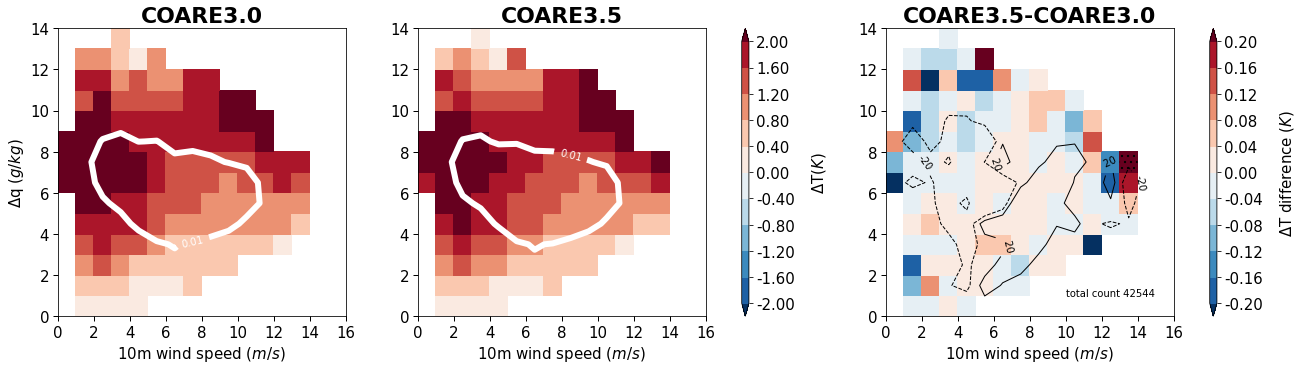

In [86]:
import matplotlib.pyplot as plt

fig = plt.figure(1,figsize=(5,5))

qlat_level = np.linspace(-2,2,11)
dqlat_level = np.linspace(-0.2,0.2,11)
qlatratio_level = np.linspace(-0.2,0.2,11)
ratiolevel = np.linspace(0.01,0.01,1)
countdifflevel = np.linspace(-20,20,2)
 
# ======== WTP qnet =========
ax1 = fig.add_axes([0,0,1,0.8])
im = (ds_coare30_bin['dT']+0.2).plot.pcolormesh(x='sfcWind',
                                          y='del_q',
                                          ax=ax1,
                                          levels=qlat_level, 
                                          extend='both', 
                                          cmap='RdBu_r',)
cb=im.colorbar
cb.remove() 
# cbaxes=fig.add_axes([0,0-0.2,0.8,0.02])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(qlat_level)
# cbar.set_ticklabels(["%0.0f"%(n) for n in qlat_level])
# cbar.ax.tick_params(labelsize=15,rotation=45) 
# cbar.set_label(label='Latent heat flux ($W/m^2$)',size=15, labelpad=15)


            
cs = (ds_coare30_bin['dT_count']/ds_coare30_bin['dT_count'].sum())\
                            .plot.contour(x='sfcWind',
                                          y='del_q',
                                          ax=ax1,
                                          levels=ratiolevel, 
                                          colors='w',linewidths=6)
ax1.clabel(cs, ratiolevel, inline=True, fmt='%0.2f', fontsize=10)

# ========== WTP qlat ===========
ax2 = fig.add_axes([1,0,1,0.8])
im = (ds_coare35_bin['dT']+0.2).plot.pcolormesh(x='sfcWind',
                                          y='del_q',
                                          ax=ax2,
                                          levels=qlat_level, 
                                          extend='both', 
                                          cmap='RdBu_r',)
cb=im.colorbar
cb.remove()
# cbaxes=fig.add_axes([1,0-0.2,0.8,0.02])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(qlat_level)
# cbar.set_ticklabels(["%0.0f"%(n) for n in qlat_level])
# cbar.ax.tick_params(labelsize=15,rotation=45) 
# cbar.set_label(label='Latent heat flux ($W/m^2$)',size=15, labelpad=15)


cs = (ds_coare35_bin['dT_count']/ds_coare35_bin['dT_count'].sum())\
                            .plot.contour(x='sfcWind',
                                          y='del_q',
                                          ax=ax2,
                                          levels=ratiolevel, 
                                          colors='w',linewidths=6)
ax2.clabel(cs, ratiolevel, inline=True, fmt='%0.2f', fontsize=10)


cbaxes=fig.add_axes([1.9,0,0.02,0.8])
cbar=fig.colorbar(im,cax=cbaxes,orientation='vertical')
cbar.set_ticks(qlat_level)
cbar.set_ticklabels(["%0.2f"%(n) for n in qlat_level])
cbar.ax.tick_params(labelsize=15,rotation=0) 
cbar.set_label(label='$\Delta$T($K$)',size=15, labelpad=15)


ax1.set_yticks(np.arange(bin2_range[0],bin2_range[1]+1,2))
ax1.set_xticks(np.arange(bin1_range[0],bin1_range[1]+1,2))
# ax1.set_yticklabels(np.arange(0,13,1), color='black',size=15)
ax1.set_xlim([bin1_range[0],bin1_range[1]])
ax1.set_ylim([bin2_range[0],bin2_range[1]])
ax1.tick_params(axis='y',labelsize=15,length=5,width=1) 
ax1.tick_params(axis='x',labelsize=15,length=5,width=1) 
# ax2.grid(linewidth=2, color='grey', alpha=0.3, linestyle='--')
ax1.set_ylabel('$\Delta$q ($g/kg$)',size=15)
ax1.set_xlabel('10m wind speed ($m/s$)',size=15)
ax1.set_title('COARE3.0',color='black', weight='bold',size=22)
# ax2.legend(loc='lower left',fontsize=20,frameon=False)

ax2.set_yticks(np.arange(bin2_range[0],bin2_range[1]+1,2))
ax2.set_xticks(np.arange(bin1_range[0],bin1_range[1]+1,2))
# ax2.set_yticklabels(np.arange(0,13,1), color='black',size=15)
ax2.set_xlim([bin1_range[0],bin1_range[1]])
ax2.set_ylim([bin2_range[0],bin2_range[1]])
ax2.tick_params(axis='y',labelsize=15,length=5,width=1) 
ax2.tick_params(axis='x',labelsize=15,length=5,width=1) 
ax2.set_ylabel('',size=15)
ax2.set_xlabel('10m wind speed ($m/s$)',size=15)
ax2.set_title('COARE3.5',color='black', weight='bold',size=22)
# ax2.legend(loc='lower left',fontsize=20,frameon=False)


# ========== WTP qlat ===========
dx=0.3

ds_diff_bin = ds_coare35_bin-ds_coare30_bin
ds_diff_bin_conf =  np.sqrt(ds_coare35_bin**2+ds_coare30_bin**2)
ds_diff_bin_ratio = (ds_coare35_bin-ds_coare30_bin)/ds_coare30_bin


ax2 = fig.add_axes([2+dx,0,1,0.8])
im = ds_diff_bin['dT'].plot.pcolormesh(x='sfcWind',
                                          y='del_q',
                                          ax=ax2,
                                          levels=dqlat_level, 
                                          extend='both', 
                                          cmap='RdBu_r',)
cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([2.9+dx,0,0.02,0.8])
cbar=fig.colorbar(im,cax=cbaxes,orientation='vertical')
cbar.set_ticks(dqlat_level)
cbar.set_ticklabels(["%0.2f"%(n) for n in dqlat_level])
cbar.ax.tick_params(labelsize=15,rotation=0) 
cbar.set_label(label='$\Delta$T difference ($K$)',size=15, labelpad=15)

biases_conf = ds_diff_bin_conf['dT_conf_%0.2f'%(stt)]\
              .where(ds_diff_bin_conf['dT_conf_%0.2f'%(stt)]<np.abs(ds_diff_bin['dT']))

y, x = np.meshgrid(np.linspace(bin2_range[0],bin2_range[1],nbin2+1),
                   np.linspace(bin1_range[0],bin1_range[1],nbin1+1))
ax2.pcolor(x,y,biases_conf,hatch='..',alpha=0)

cs = (ds_diff_bin['dT_count'])\
                            .plot.contour(x='sfcWind',
                                          y='del_q',
                                          ax=ax2,
                                          levels=countdifflevel, 
                                          colors='k',linewidths=1)
totcount = ds_coare35_bin['dT_count'].sum()
ax2.clabel(cs, countdifflevel, inline=True, fmt='%3.0f', fontsize=10)



ax2.set_title('COARE3.5-COARE3.0',color='black', weight='bold',size=22)
ax2.text(10,1,'total count %i'%totcount)

ax2.set_yticks(np.arange(bin2_range[0],bin2_range[1]+1,2))
ax2.set_xticks(np.arange(bin1_range[0],bin1_range[1]+1,2))
# ax2.set_yticklabels(np.arange(0,13,1), color='black',size=15)
ax2.set_xlim([bin1_range[0],bin1_range[1]])
ax2.set_ylim([bin2_range[0],bin2_range[1]])
ax2.tick_params(axis='y',labelsize=15,length=5,width=1) 
ax2.tick_params(axis='x',labelsize=15,length=5,width=1) 
ax2.set_ylabel('',size=15)
ax2.set_xlabel('10m wind speed ($m/s$)',size=15)
# ax2.set_title('ETP (obs)',color='black', weight='bold',size=22)
# ax2.legend(loc='lower left',fontsize=20,frameon=False)

fig.savefig('../figure/dTmatrix_coare_comp.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)